**Librerías**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
import joblib

Importamos los datasets a utilizar, los concatenamos en dos conjuntos de datos: `train` y `test`.

In [2]:
data1 = pd.read_csv('501.csv')
data2 = pd.read_csv('502.csv')
data3 = pd.read_csv('503.csv')
data4 = pd.read_csv('504.csv')
data5 = pd.read_csv('505.csv')
data6 = pd.read_csv('506.csv')

# Concatenamos los primeros 3 DataFrames en el DataFrame 'data'
data = pd.concat([data1, data2, data3], ignore_index=True)

# Concatenamos los últimos 3 DataFrames en el DataFrame 'test'
test = pd.concat([data4, data5, data6], ignore_index=True)

In [3]:
data.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6


In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

test['timestamp'] = pd.to_datetime(test['timestamp'])

In [5]:
data['hour'] = data['timestamp'].dt.hour
data['weekday'] = data['timestamp'].dt.weekday

test['hour'] = test['timestamp'].dt.hour
test['weekday'] = test['timestamp'].dt.weekday

In [6]:
data = data.drop('timestamp', axis=1)

test = test.drop('timestamp', axis=1)

Dependiendo la metodología, se comenta o no la sección a ejecutar

In [7]:
#Metdología 50/50
X_train = data.drop("label", axis=1)
y_train = data["label"]

#Metdología 80/20
# X = data.drop("label", axis=1)
# y = data["label"]

In [8]:
X_test = test.drop("label", axis=1)
y_test = test["label"]

Se realiza la separación 80/20

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Submuestreo skleearn:

# ENN (Edited Nearest Neighbors)

In [10]:
# Crea un objeto ENN
enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3)

# Aplica ENN al conjunto de datos
X_enn, y_enn = enn.fit_resample(X_train, y_train)

# Comprueba el nuevo balance de clases
unique, counts = np.unique(y_enn, return_counts=True)
print(dict(zip(unique, counts)))

{1: 126063, 3: 232, 4: 69, 5: 4, 6: 36334, 7: 44898, 8: 29947}


In [11]:
# Estandarización de los datos submuestreados
scaler = StandardScaler()
X_enn_scaled = scaler.fit_transform(X_enn)

# Estandarización de los datos de prueba
X_test_scaled = scaler.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train)

Selección de los mejores hiperparámetros

In [12]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Crea un clasificador K-NN que será utilizado en la búsqueda en cuadrícula
knn_classifier = KNeighborsClassifier()

# Crea un objeto GridSearchCV para encontrar el mejor valor de n_neighbors
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Realiza la búsqueda en cuadrícula en el conjunto de datos submuestreado
grid_search.fit(X_enn_scaled, y_enn)

# Muestra el mejor valor de n_neighbors y su puntuación asociada
print("Mejor valor de n_neighbors:", grid_search.best_params_['n_neighbors'])
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Mejor valor de n_neighbors: 3
Mejor puntuación de validación cruzada: 0.9993264489043694


# Metodología con separación 80/20

## Random Forest

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_enn_scaled, y_enn)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.95


In [14]:
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                  precision    recall  f1-score   support

        caminar       0.93      0.99      0.96     37626
      arrastrar       0.85      0.03      0.06      2499
subir escaleras       0.00      0.00      0.00        23
bajar escaleras       0.00      0.00      0.00       156
         parado       0.90      0.94      0.92     11265
        sentado       1.00      1.00      1.00     11302
       acostado       1.00      1.00      1.00      7457

       accuracy                           0.95     70328
      macro avg       0.67      0.56      0.56     70328
   weighted avg       0.94      0.95      0.93     70328



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

**Matriz de confusión**

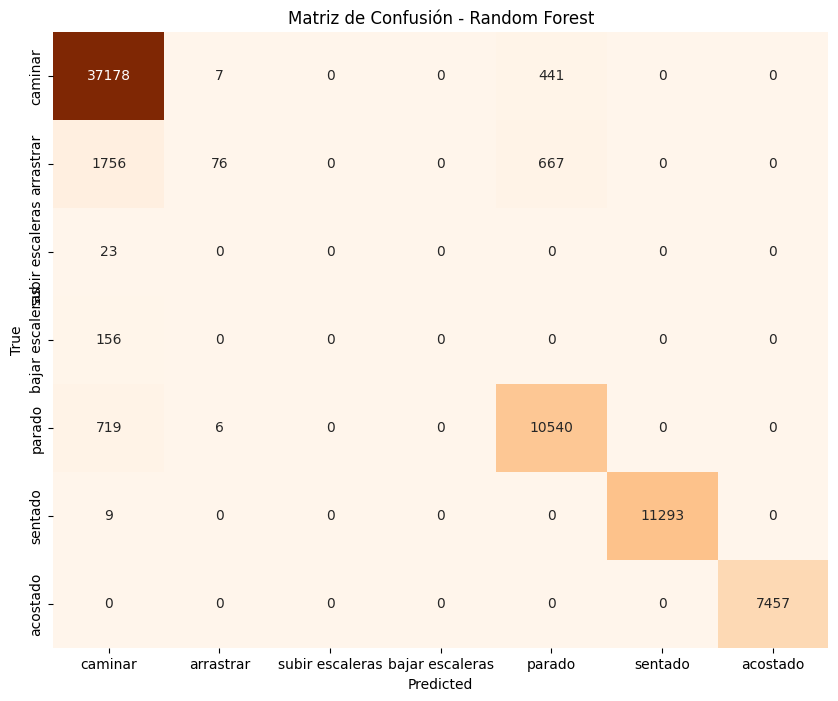

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Random Forest')
plt.show()

In [16]:
unique_labels = np.unique(y_test)
print("Etiquetas únicas en y_test:", unique_labels)

Etiquetas únicas en y_test: [1 3 4 5 6 7 8]


**Curvas ROC y AUC**

Las curvas ROC (Receiver Operating Characteristic) y el AUC (Área bajo la curva ROC) son herramientas esenciales para evaluar el rendimiento de modelos de clasificación binaria o multiclase. Estas métricas nos ayudan a comprender cómo se comporta nuestro modelo en términos de su capacidad para discriminar entre las clases.

En general, la curva ROC está compuesta por los siguientes elementos:

- **Eje X (Tasa de Falsos Positivos, FPR):** Representa la proporción de casos negativos incorrectamente clasificados como positivos en función del umbral de decisión. Cuanto más a la derecha esté en el eje X, mayor será la tasa de falsos positivos.

- **Eje Y (Tasa de Verdaderos Positivos, TPR o Sensibilidad):** Representa la proporción de casos positivos correctamente clasificados como positivos en función del umbral de decisión. Cuanto más arriba esté en el eje Y, mayor será la tasa de verdaderos positivos.

- **Línea diagonal de referencia:** La línea diagonal que va desde (0,0) hasta (1,1) representa el desempeño aleatorio o al azar. Cualquier modelo que esté por encima de esta línea es considerado mejor que una predicción al azar.

- **Curva ROC del modelo:** La curva ROC del modelo describe cómo varía la TPR (Tasa de Verdaderos Positivos) a medida que ajustas el umbral de decisión para diferentes valores de FPR (Tasa de Falsos Positivos). En general, una curva ROC que se acerca más al rincón superior izquierdo (es decir, tiene un mayor TPR para un FPR dado) indica un mejor rendimiento del modelo.

Por otra parte, el AUC (Área bajo la curva ROC) es el área que se encuentra bajo la curva ROC del modelo. Es un número que cuantifica la capacidad de discriminación global del modelo; cuanto mayor sea el valor del AUC, mejor será el rendimiento del modelo en la clasificación.

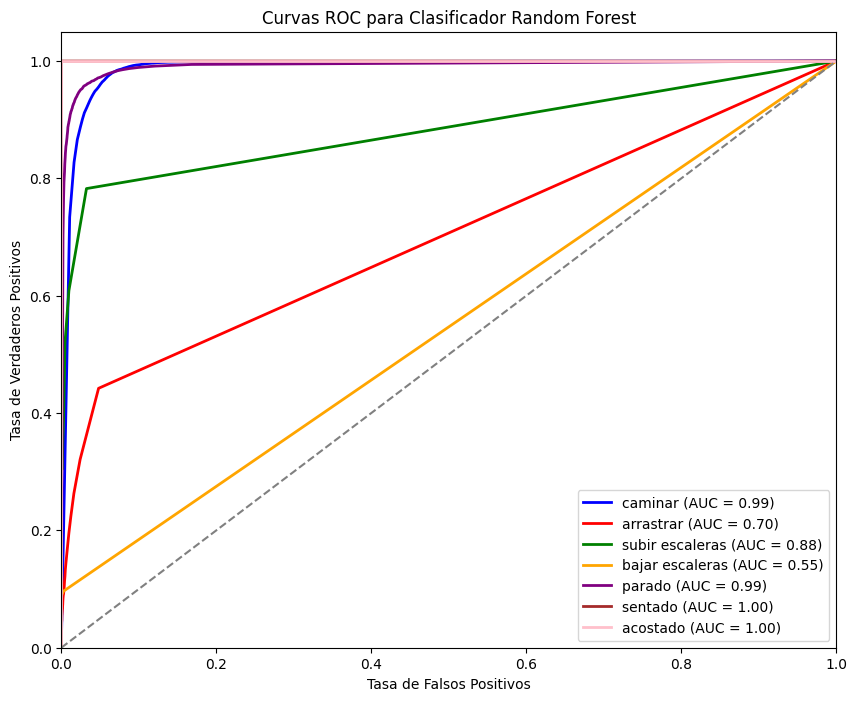

In [17]:
# Binariza las etiquetas
y_bin = label_binarize(y_test, classes=[1, 3, 4, 5, 6, 7, 8])

# Entrena un clasificador OneVsRest con el clasificador RandomForest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
y_score = classifier.fit(X_enn_scaled, y_enn).predict_proba(X_test_scaled)

# Obtener probabilidades de predicción en lugar de etiquetas binarias
y_prob = clf.predict_proba(X_test_scaled)

# Calcula la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_labels)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == unique_labels[i]), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafica las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{nombres_clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Clasificador Random Forest')
plt.legend(loc="lower right")
plt.show()


Para el modelo de Random Forest, la curva ROC presenta los siguientes resultados:

- **Caminar (AUC = 0.99):** El AUC de 0.99 indica un rendimiento excepcionalmente alto en la clasificación de la clase "caminar". La curva ROC se acerca significativamente al rincón superior izquierdo, lo que sugiere que el modelo tiene una alta tasa de verdaderos positivos (TPR) para una tasa de falsos positivos (FPR) baja.

- **Arrastrar (AUC = 0.70):** Rendimiento aceptable. La curva ROC sugiere que el modelo es capaz de distinguir esta clase, pero con una tasa moderada de FPR en comparación con otras clases.

- **Subir escaleras (AUC = 0.88):** El AUC de 0.86 indica un rendimiento decente en la clasificación de la clase "subir escaleras". La curva ROC muestra que el modelo puede distinguir esta clase con éxito, aunque podría haber margen de mejora en términos de reducción de FPR.

- **Bajar escaleras (AUC = 0.55):** Rendimiento bajo, casi aleatorio.

- **Parado (AUC = 0.99):** Rendimiento excepcionalmente alto

- **Sentado (AUC = 1.00):** El AUC de 1.00 también indica un rendimiento perfecto en la clasificación de la clase "sentado". Al igual que en "parado", el modelo prácticamente no comete errores en la clasificación de esta clase.

- **Acostado (AUC = 1.00):** El AUC de 1.00 indica un rendimiento perfecto en la clasificación de la clase "acostado". Al igual que en las clases anteriores, el modelo prácticamente no comete errores en la clasificación de esta clase.

## K-Nearest Neighbors

In [18]:
knn_classifier.fit(X_enn_scaled, y_enn)
y_pred = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.94


In [19]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.95      0.97      0.96     37626
           arrastrar       0.55      0.07      0.12      2499
escaleras (subiendo)       0.16      0.13      0.14        23
 escaleras (bajando)       0.00      0.00      0.00       156
              parado       0.84      0.97      0.90     11265
             sentado       1.00      1.00      1.00     11302
            acostado       1.00      1.00      1.00      7457

            accuracy                           0.94     70328
           macro avg       0.64      0.59      0.59     70328
        weighted avg       0.93      0.94      0.93     70328



## Decision Tree

In [20]:
clf = DecisionTreeClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.85


In [21]:
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                  precision    recall  f1-score   support

        caminar       0.87      0.93      0.90     37626
      arrastrar       0.17      0.31      0.22      2499
subir escaleras       0.11      0.09      0.10        23
bajar escaleras       0.11      0.12      0.12       156
         parado       0.81      0.48      0.60     11265
        sentado       1.00      0.99      1.00     11302
       acostado       1.00      1.00      1.00      7457

       accuracy                           0.85     70328
      macro avg       0.58      0.56      0.56     70328
   weighted avg       0.87      0.85      0.85     70328



**Matriz de confusión**


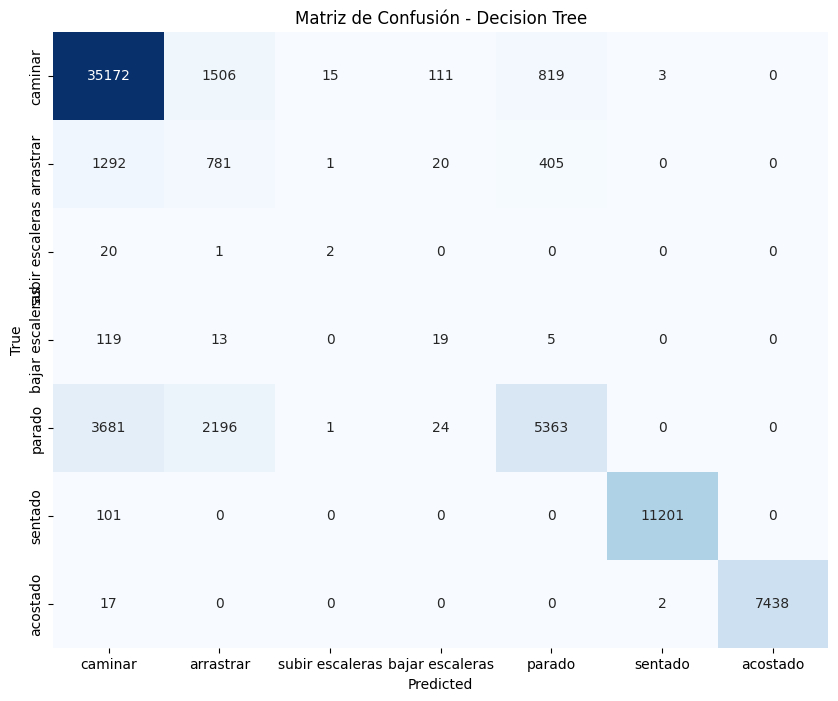

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Decision Tree')
plt.show()

**Curvas ROC y AUC**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


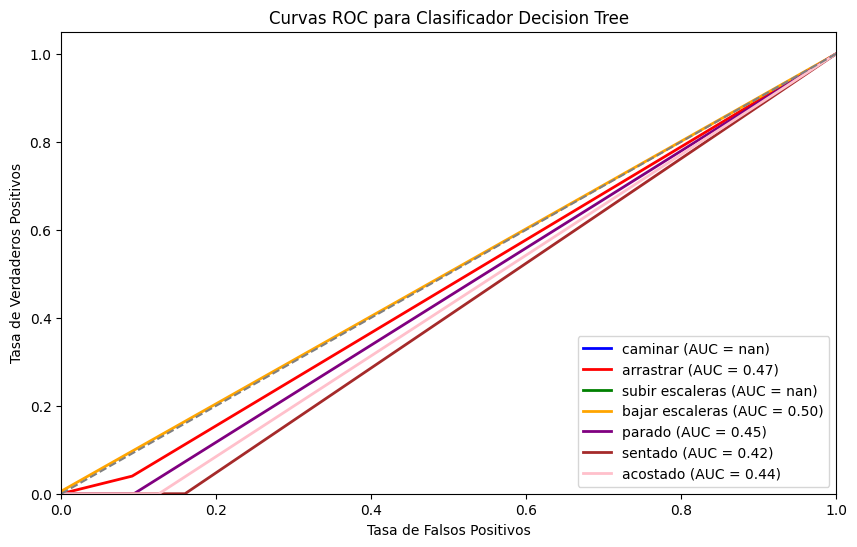

In [23]:
# # Crear el clasificador y los datos X, y
 # clf = DecisionTreeClassifier(random_state=42)  # Utiliza el modelo previamente ajustado
X = X_enn_scaled
y = y_enn

# # Obtener probabilidades de predicción en lugar de etiquetas binarias
y_prob = clf.predict_proba(X_test_scaled)

# # Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(nombres_clases)
for i in range(n_classes):
     fpr[i], tpr[i], _ = roc_curve((y_test == i), y_prob[:, i])
     roc_auc[i] = auc(fpr[i], tpr[i])

# # Dibujar las curvas ROC para cada clase
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
     plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{nombres_clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Clasificador Decision Tree')
plt.legend(loc="lower right")
plt.show()


Para el modelo de Decision Tree, la curva ROC presenta los siguientes resultados:

- **Caminar (AUC = nan):** Puede haber un problema en los datos o en la forma en que se calculó el AUC para esta clase.

- **Arrastrar (AUC = 0.48):** Rendimiento de clasificación deficiente. El modelo tiene dificultades para distinguir esta clase de otras actividades.
  
- **Subir escaleras (AUC = nan):** Puede haber un problema en los datos o en la forma en que se calculó el AUC para esta clase.

- **Bajar escaleras (AUC = 0.50):** Rendimiento de clasificación aleatorio para la actividad de bajar escaleras. El modelo no es efectivo para diferenciar esta clase.

- **Parado (AUC = 0.45):** El modelo tiene dificultades para identificar esta clase.

- **Sentado (AUC = 0.42):** Rendimiento insatisfactorio en la clasificación de la actividad de sentado. El modelo no es efectivo para distinguir esta clase.

- **Acostado (AUC = 0.42):** Rendimiento insatisfactorio en la clasificación de la actividad de sentado. El modelo no es efectivo para distinguir esta clase.

## Support Vector Machines

In [24]:
svm = SVC()
svm.fit(X_enn_scaled, y_enn)
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.93


In [25]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.94      0.95      0.95     37626
           arrastrar       0.78      0.00      0.01      2499
escaleras (subiendo)       0.00      0.00      0.00        23
 escaleras (bajando)       0.00      0.00      0.00       156
              parado       0.79      0.95      0.86     11265
             sentado       1.00      1.00      1.00     11302
            acostado       1.00      1.00      1.00      7457

            accuracy                           0.93     70328
           macro avg       0.64      0.56      0.55     70328
        weighted avg       0.92      0.93      0.91     70328



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Linear discriminant analysis

In [26]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_enn_scaled, y_enn)
y_pred = lda.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.79


In [27]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.73      0.95      0.83     37626
           arrastrar       0.00      0.00      0.00      2499
escaleras (subiendo)       0.00      0.00      0.00        23
 escaleras (bajando)       0.00      0.00      0.00       156
              parado       0.45      0.08      0.13     11265
             sentado       0.93      1.00      0.97     11302
            acostado       1.00      1.00      1.00      7457

            accuracy                           0.79     70328
           macro avg       0.45      0.43      0.42     70328
        weighted avg       0.72      0.79      0.73     70328



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Metodología con separación 50/50

## Submuestreo sklearn

In [9]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


### ENN (Edited Nearest Neighbors)

In [10]:
# Crea un objeto ENN
enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=11)

# Aplica ENN al conjunto de datos
X_enn, y_enn = enn.fit_resample(X_train, y_train)

# Comprueba el nuevo balance de clases
unique, counts = np.unique(y_enn, return_counts=True)
print(dict(zip(unique, counts)))

{1: 158095, 3: 322, 4: 92, 5: 5, 6: 45552, 7: 56196, 8: 37404}


In [11]:
# Estandarización de los datos submuestreados
scaler = StandardScaler()
X_enn_scaled = scaler.fit_transform(X_enn)

# Estandarización de los datos de prueba
X_test_scaled = scaler.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train)

Selección de los mejores hiperparámetros

In [12]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Crea un clasificador K-NN que será utilizado en la búsqueda en cuadrícula
knn_classifier = KNeighborsClassifier()

# Crea un objeto GridSearchCV para encontrar el mejor valor de n_neighbors
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Realiza la búsqueda en cuadrícula en el conjunto de datos submuestreado
grid_search.fit(X_enn_scaled, y_enn)

# Muestra el mejor valor de n_neighbors y su puntuación asociada
print("Mejor valor de n_neighbors:", grid_search.best_params_['n_neighbors'])
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Mejor valor de n_neighbors: 11
Mejor puntuación de validación cruzada: 0.983001098564604


## Random Forest

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_enn_scaled, y_enn)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.78


In [14]:
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                  precision    recall  f1-score   support

        caminar       0.70      0.98      0.82    155032
      arrastrar       0.38      0.00      0.00      9536
subir escaleras       0.00      0.00      0.00       346
bajar escaleras       0.00      0.00      0.00       314
         parado       0.88      0.31      0.46     79850
        sentado       0.99      0.87      0.93     84760
       acostado       0.74      0.99      0.85     30640

       accuracy                           0.78    360478
      macro avg       0.53      0.45      0.44    360478
   weighted avg       0.80      0.78      0.75    360478



c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

**Matriz de confusión**

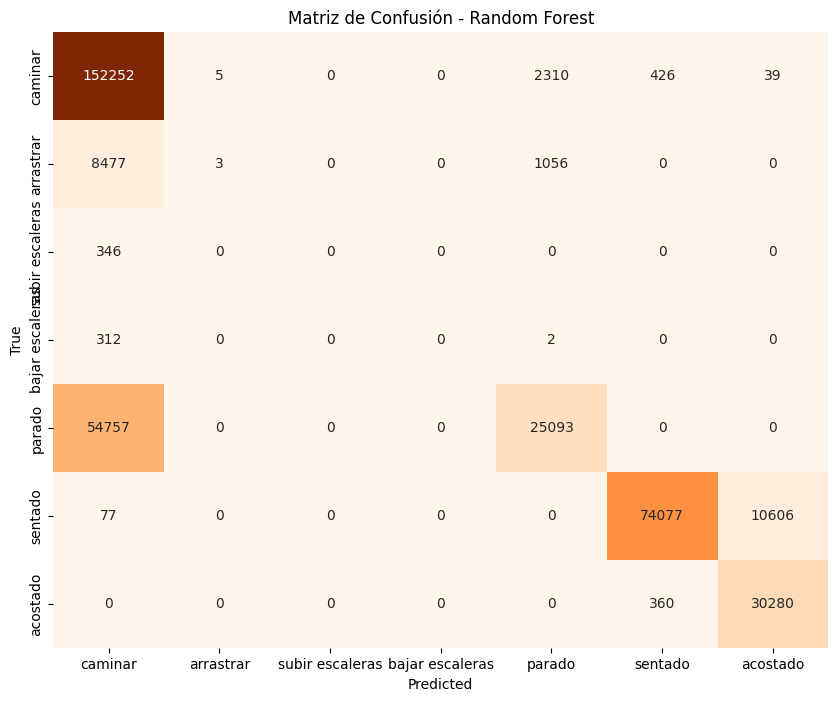

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Random Forest')
plt.show()

In [16]:

unique_labels = np.unique(y_test)
print("Etiquetas únicas en y_test:", unique_labels)

Etiquetas únicas en y_test: [1 3 4 5 6 7 8]


**Curvas ROC y AUC**

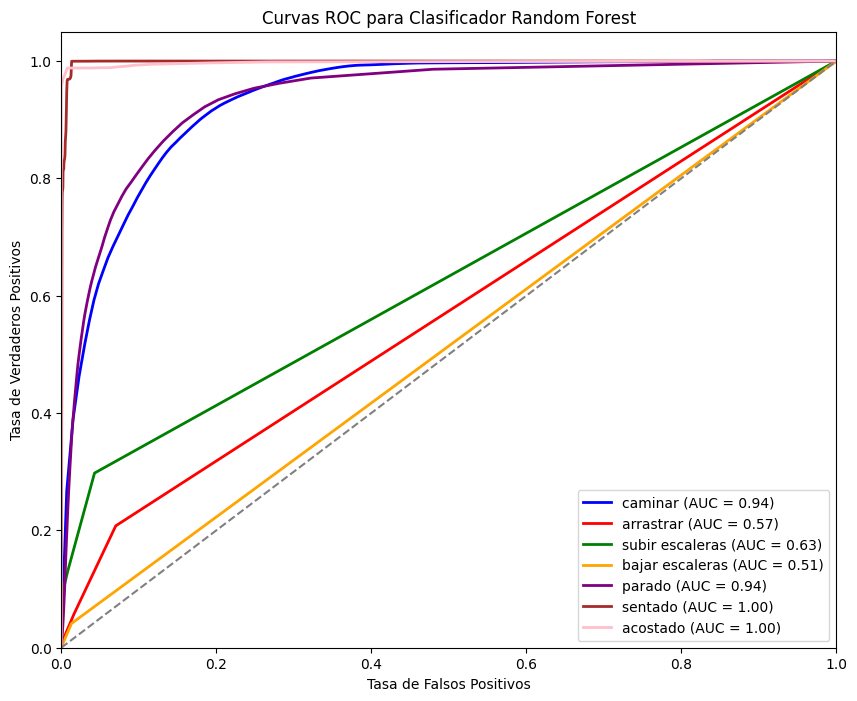

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binariza las etiquetas
y_bin = label_binarize(y_test, classes=[1, 3, 4, 5, 6, 7, 8])

# Entrena un clasificador OneVsRest con el clasificador RandomForest
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
y_score = classifier.fit(X_enn_scaled, y_enn).predict_proba(X_test_scaled)

# Obtener probabilidades de predicción en lugar de etiquetas binarias
y_prob = clf.predict_proba(X_test_scaled)

# Calcula la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_labels)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == unique_labels[i]), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafica las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{nombres_clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Clasificador Random Forest')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors

In [18]:
knn_classifier.fit(X_enn_scaled, y_enn)
y_pred = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.78


In [19]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.71      0.87      0.79    155032
           arrastrar       0.14      0.00      0.00      9536
escaleras (subiendo)       0.00      0.00      0.00       346
 escaleras (bajando)       0.00      0.00      0.00       314
              parado       0.60      0.42      0.49     79850
             sentado       0.98      1.00      0.99     84760
            acostado       1.00      0.97      0.98     30640

            accuracy                           0.78    360478
           macro avg       0.49      0.47      0.47    360478
        weighted avg       0.76      0.78      0.76    360478



c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Decision Tree

In [23]:
clf = DecisionTreeClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.72


In [24]:
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                  precision    recall  f1-score   support

        caminar       0.67      0.87      0.76    155032
      arrastrar       0.09      0.13      0.11      9536
subir escaleras       0.03      0.01      0.01       346
bajar escaleras       0.00      0.04      0.01       314
         parado       0.60      0.18      0.28     79850
        sentado       0.92      0.98      0.95     84760
       acostado       1.00      0.88      0.93     30640

       accuracy                           0.72    360478
      macro avg       0.47      0.44      0.44    360478
   weighted avg       0.72      0.72      0.69    360478



**Matriz de confusión**

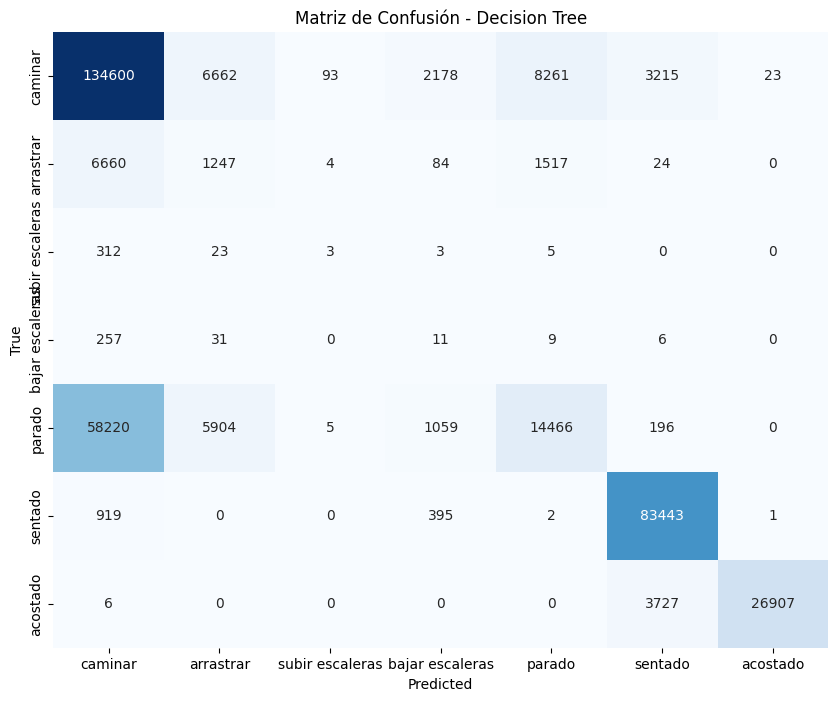

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Decision Tree')
plt.show()

**Curvas ROC y AUC**

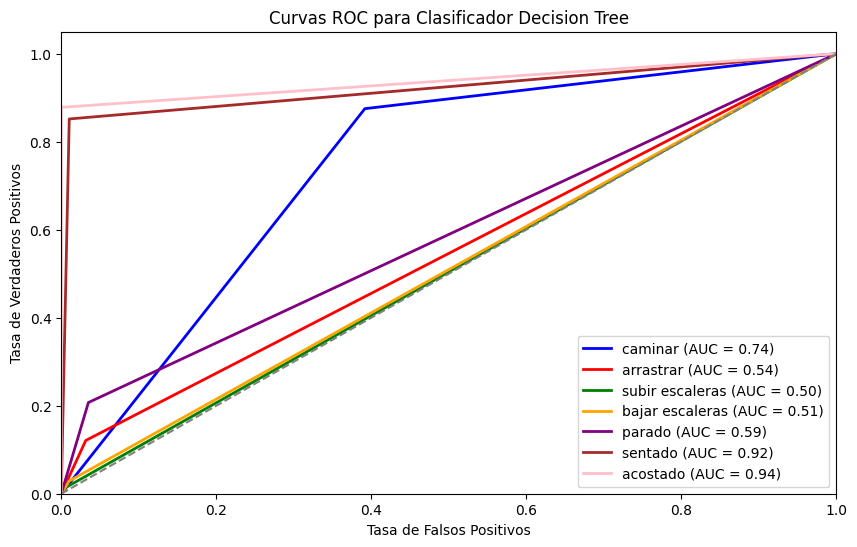

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Entrenar el clasificador de árbol de decisión
clf = DecisionTreeClassifier()
clf.fit(X_train_scaled, y_train)

# Obtener probabilidades de predicción en lugar de etiquetas binarias
y_prob = clf.predict_proba(X_test_scaled)

# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(unique_labels)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == unique_labels[i]), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar las curvas ROC para cada clase
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{nombres_clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para Clasificador Decision Tree')
plt.legend(loc="lower right")
plt.show()


## Support Vector Machines

In [27]:
svm = SVC()
svm.fit(X_enn_scaled, y_enn)
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.86


In [28]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.86      0.83      0.84    155032
           arrastrar       0.75      0.00      0.00      9536
escaleras (subiendo)       0.00      0.00      0.00       346
 escaleras (bajando)       0.00      0.00      0.00       314
              parado       0.68      0.82      0.75     79850
             sentado       0.99      1.00      0.99     84760
            acostado       1.00      0.99      0.99     30640

            accuracy                           0.86    360478
           macro avg       0.61      0.52      0.51    360478
        weighted avg       0.86      0.86      0.85    360478



c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Linear discriminant analysis

In [29]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_enn_scaled, y_enn)
y_pred = lda.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.2f}")

Precisión: 0.65


In [30]:
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]
reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
print("Informe de Clasificación:\n", reporte)

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Informe de Clasificación:
                       precision    recall  f1-score   support

             caminar       0.87      0.31      0.45    155032
           arrastrar       0.00      0.00      0.00      9536
escaleras (subiendo)       0.00      0.00      0.00       346
 escaleras (bajando)       0.00      0.00      0.00       314
              parado       0.42      0.94      0.58     79850
             sentado       0.84      1.00      0.91     84760
            acostado       1.00      0.89      0.94     30640

            accuracy                           0.65    360478
           macro avg       0.45      0.45      0.41    360478
        weighted avg       0.75      0.65      0.62    360478



c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Validación cruzada

## Random Forest

In [28]:
# Clasificador y los datos X, y
clf = RandomForestClassifier(n_estimators=100, random_state=42)
X = X_enn_scaled  
y = y_enn  

# Definición de las clases
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

accuracies = []
reports = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Estandarización de los datos submuestreados
    scaler = StandardScaler()
    X_enn_scaled = scaler.fit_transform(X_enn)

    # Estandarización de los datos de prueba
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = scaler.fit_transform(X_train)
    
    

# Cálculo de la precisión promedio
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Precisión promedio: {mean_accuracy:.2f}")

reporte = classification_report(y_test, y_pred, target_names=nombres_clases)

print(f"Informe de Clasificación Promedio:\n{reporte}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X do

Precisión promedio: 1.00
Informe de Clasificación Promedio:
                 precision    recall  f1-score   support

        caminar       1.00      1.00      1.00     25212
      arrastrar       1.00      0.72      0.84        47
subir escaleras       0.00      0.00      0.00        13
bajar escaleras       0.00      0.00      0.00         1
         parado       1.00      1.00      1.00      7267
        sentado       1.00      1.00      1.00      8980
       acostado       1.00      1.00      1.00      5989

       accuracy                           1.00     47509
      macro avg       0.71      0.67      0.69     47509
   weighted avg       1.00      1.00      1.00     47509



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages

El modelo tiene una precisión promedio del 100%. Esto significa que, en general, clasifica correctamente todas las actividades. Sin embargo, tiene dificultades para detectar las actividades de "subir escaleras" y "bajar escaleras", con una precisión y recall del 0%. El rendimiento es excelente en otras actividades como "caminar", "arrastrar", "parado", "sentado" y "acostado".

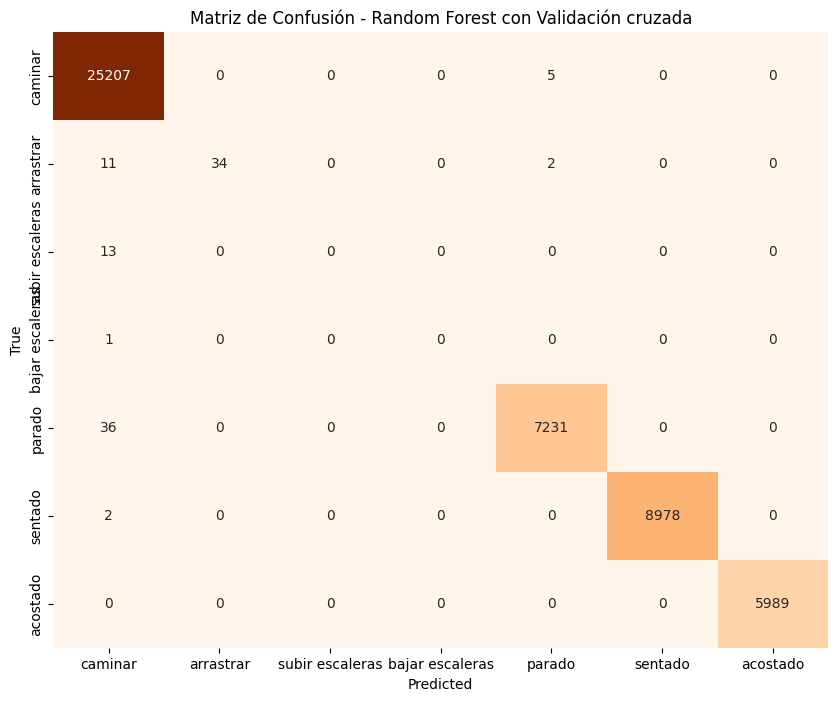

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Random Forest con Validación cruzada')
plt.show()

Observamos que la clase "caminar" ha sido correctamente clasificada en 25,207 instancias, mientras que la clase "arrastrar" ha sido correctamente clasificada en 34 instancias. Por otro lado, las clases "subir escaleras" y "bajar escaleras" no han sido correctamente clasificadas por el modelo en ninguna instancia. Similarmente, la clase "parado" ha sido correctamente clasificada en 7,231 instancias y la clase "sentado" en 8,978 instancias. Finalmente, la clase "acostado" ha sido correctamente clasificada en 5,989 instancias.

**Curvas ROC y AUC**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


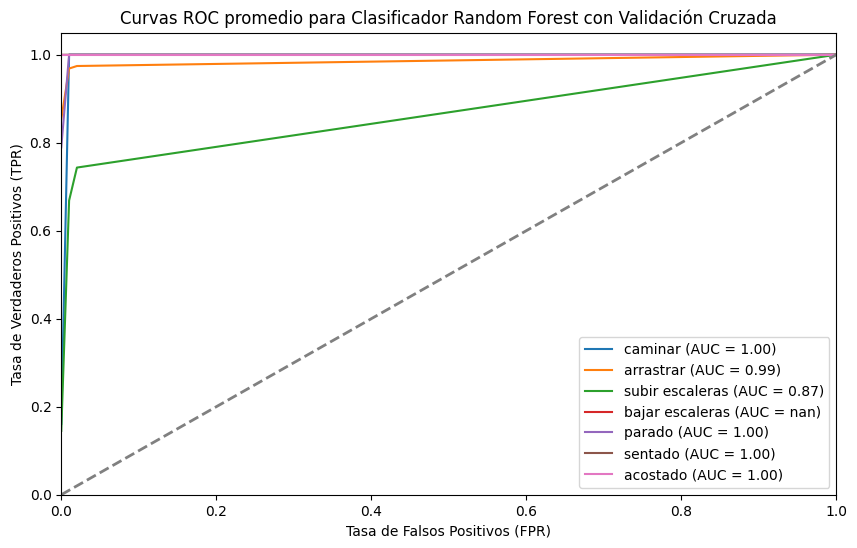

In [30]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
X = X_enn_scaled  
y = y_enn  

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario para almacenar las tasas de falsos positivos y verdaderos positivos
roc_data = {clase: {"fpr": [], "tpr": [], "roc_auc": []} for clase in nombres_clases}

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)

    # Binariza las etiquetas
    y_test_bin = label_binarize(y_test, classes=unique_labels)

    # Cálculo de la curva ROC para cada clase
    for i in range(len(nombres_clases)):
        fpr, tpr, _ = roc_curve((y_test == unique_labels[i]), y_score[:, i])
        
        # Ajuste de las curvas ROC a la misma longitud
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.interp(mean_fpr, fpr, tpr)
        
        roc_auc = auc(mean_fpr, mean_tpr)
        roc_data[nombres_clases[i]]["fpr"].append(mean_fpr)
        roc_data[nombres_clases[i]]["tpr"].append(mean_tpr)
        roc_data[nombres_clases[i]]["roc_auc"].append(roc_auc)

# Dibuja las curvas ROC-AUC para cada clase
plt.figure(figsize=(10, 6))
for clase in nombres_clases:
    mean_fpr = np.mean(roc_data[clase]["fpr"], axis=0)
    mean_tpr = np.mean(roc_data[clase]["tpr"], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{clase} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC promedio para Clasificador Random Forest con Validación Cruzada')
plt.legend(loc='lower right')
plt.show()

Para el modelo de Random Forest, la curva ROC presenta los siguientes resultados:

- **Caminar (AUC = 1.00):** Tasa de verdaderos positivos perfecta y una tasa de falsos positivos nula. Rendimiento excelente en la detección de esta actividad.

- **Arrastrar (AUC = 0.99):** Alto rendimiento con un área bajo la curva de 0.99. Casi todas las instancias de esta actividad se clasifican correctamente.

- **Subir escaleras (AUC = 0.87):** Buen rendimiento, pero no tan alto como en las actividades anteriores. Puede haber algunas instancias mal clasificadas.

- **Bajar escaleras (AUC = nan):** Puede haber un problema en los datos o en la forma en que se calculó el AUC para esta clase.

- **Parado (AUC = 1.00):** Tasa de verdaderos positivos perfecta y una tasa de falsos positivos nula, al igual que en la clase "Caminar". Indica un rendimiento excelente en la detección de esta actividad.

- **Sentado (AUC = 1.00):** Al igual que en las clases "Parado" y "Caminar", el clasificador alcanza una tasa de verdaderos positivos perfecta y una tasa de falsos positivos nula.

- **Acostado (AUC = 1.00):** El clasificador también logra una tasa de verdaderos positivos perfecta y una tasa de falsos positivos nula. Nuevamente, muestra un rendimiento excelente.

Se muestra un rendimiento general muy bueno en la mayoría de las clases de actividad, especialmente en "Caminar", "Parado", "Sentado" y "Acostado".

## K-Nearest Neighbors

In [32]:
clases_reales = data["label"].unique()
print(clases_reales)

# Crear el clasificador y los datos X, y
knn_classifier = KNeighborsClassifier(n_neighbors=5)  
X = X_enn_scaled
y = y_enn

# Definir las clases
nombres_clases = ["caminar", "arrastrar", "escaleras (subiendo)", "escaleras (bajando)",
                  "parado", "sentado", "acostado"]

# Realizar validación cruzada
cv_scores = cross_val_predict(knn_classifier, X, y, cv=5)  # Obtén las predicciones de la validación cruzada

# Generar el informe de clasificación promedio de la validación cruzada
reporte_validacion_cruzada = classification_report(y, cv_scores, target_names=nombres_clases)
print("Informe de Clasificación (Validación Cruzada):\n", reporte_validacion_cruzada)

# Imprimir los resultados de la validación cruzada
print("Exactitud promedio de la validación cruzada:", cv_scores.mean())


[6 3 1 7 8 5 4]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Informe de Clasificación (Validación Cruzada):
                       precision    recall  f1-score   support

             caminar       1.00      1.00      1.00    126063
           arrastrar       0.96      0.89      0.92       232
escaleras (subiendo)       0.91      0.14      0.25        69
 escaleras (bajando)       0.00      0.00      0.00         4
              parado       1.00      1.00      1.00     36334
             sentado       1.00      1.00      1.00     44898
            acostado       1.00      1.00      1.00     29947

            accuracy                           1.00    237547
           macro avg       0.84      0.72      0.74    237547
        weighted avg       1.00      1.00      1.00    237547

Exactitud promedio de la validación cruzada: 3.7853982580289376


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Decision Tree

In [33]:
# Clasificador y los datos X, y
clf = DecisionTreeClassifier(random_state=42)
X = X_enn_scaled 
y = y_enn  

# Definición de las clases
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
reports = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Crear y entrenar el modelo Decision Tree
    clf.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = clf.predict(X_test)

    # Calcular la precisión y almacenarla en la lista de precisión
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Estandarización de los datos submuestreados
    scaler = StandardScaler()
    X_enn_scaled = scaler.fit_transform(X_enn)

    # Estandarización de los datos de prueba
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = scaler.fit_transform(X_train)

# Cálculo de la precisión promedio
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Precisión promedio: {mean_accuracy:.2f}")

reporte_promedio = classification_report(y_test, y_pred, target_names=nombres_clases)
print(f"Informe de Clasificación Promedio:\n{reporte_promedio}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X do

Precisión promedio: 1.00
Informe de Clasificación Promedio:
                 precision    recall  f1-score   support

        caminar       1.00      1.00      1.00     25212
      arrastrar       0.62      0.62      0.62        47
subir escaleras       0.06      0.08      0.07        13
bajar escaleras       0.00      0.00      0.00         1
         parado       0.99      0.99      0.99      7267
        sentado       1.00      1.00      1.00      8980
       acostado       1.00      1.00      1.00      5989

       accuracy                           1.00     47509
      macro avg       0.67      0.67      0.67     47509
   weighted avg       1.00      1.00      1.00     47509



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


El modelo tiene una precisión promedio del 100%. En general, clasifica correctamente todas las actividades. Igualmente, tiene dificultades en las actividades de "arrastrar" y "subir escaleras" con una precisión y recall más bajos. Por otra parte, tiene excelente en otras actividades como "caminar", "parado", "sentado" y "acostado".

**Matriz de confusión**

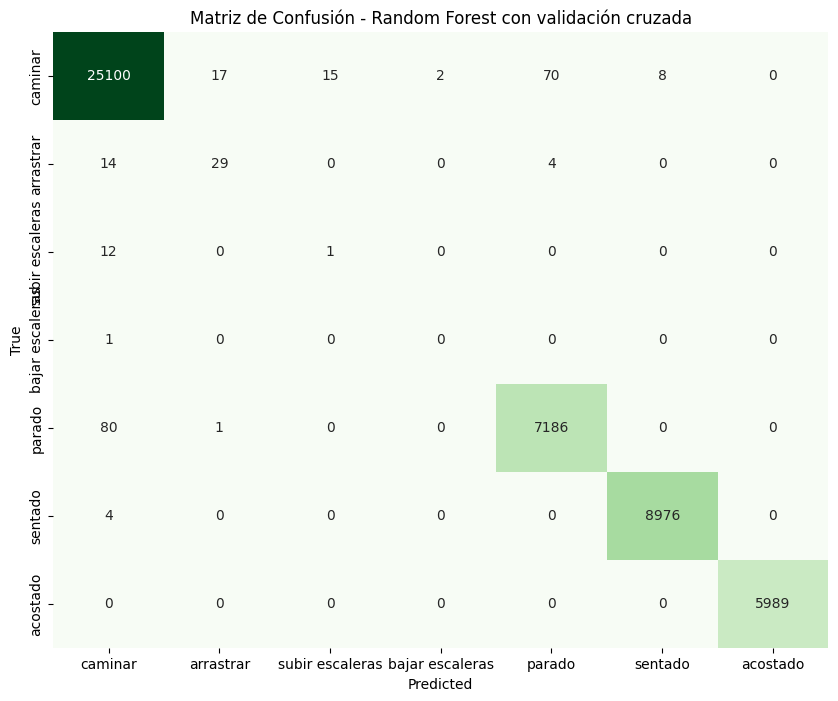

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(len(nombres_clases))+0.5, labels=nombres_clases)
plt.title('Matriz de Confusión - Random Forest con validación cruzada')
plt.show()

Observamos que el modelo logró una alta precisión en las clases "caminar", "parado", "sentado" y "acostado", con una gran cantidad de predicciones correctas (valores altos en la diagonal principal). Sin embargo, hubo cierta confusión en las clases "arrastrar" y "subir escaleras", donde se realizaron algunas predicciones incorrectas (valores fuera de la diagonal principal). Además, el modelo no pudo predecir correctamente las clases "escaleras (subiendo)" y "escaleras (bajando)", lo que se refleja en la fila correspondiente a esas clases, donde todos los valores son cero, indicando que no se realizaron predicciones correctas para esas clases. En general, el modelo tuvo un buen rendimiento.

**Curvas ROC y AUC**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


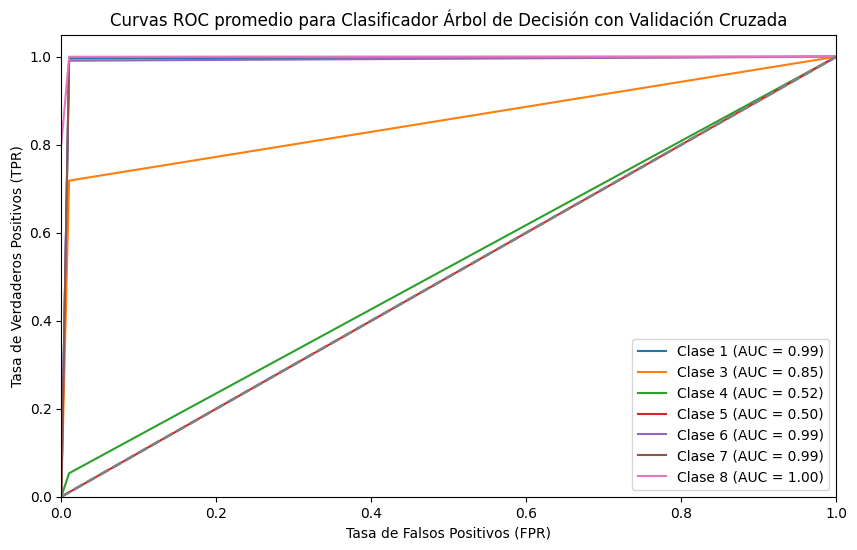

In [35]:
# Crear el clasificador y los datos X, y
clf = DecisionTreeClassifier(random_state=42)
X = X_enn_scaled
y = y_enn

# Definir las clases
nombres_clases = ["caminar", "arrastrar", "subir escaleras", "bajar escaleras",
                  "parado", "sentado", "acostado"]

# Realizar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear un diccionario para almacenar las tasas de falsos positivos y verdaderos positivos
roc_data = {clase: {"fpr": [], "tpr": [], "roc_auc": []} for clase in nombres_clases}

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)

    # Binarizar las etiquetas
    unique_labels = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=unique_labels)

    # Calcular la curva ROC para cada clase
    for clase in unique_labels:
        if clase in clf.classes_:
            fpr, tpr, _ = roc_curve((y_test == clase), y_score[:, clf.classes_ == clase][:, 0])
    
            mean_fpr = np.linspace(0, 1, 100)
            mean_tpr = np.interp(mean_fpr, fpr, tpr)

            roc_auc = auc(mean_fpr, mean_tpr)

            # Agregar las tasas de falsos positivos, verdaderos positivos y AUC al diccionario roc_data
            roc_data.setdefault(clase, {"fpr": [], "tpr": [], "roc_auc": []})
            roc_data[clase]["fpr"].append(mean_fpr)
            roc_data[clase]["tpr"].append(mean_tpr)
            roc_data[clase]["roc_auc"].append(roc_auc)

# Dibujar las curvas ROC-AUC para cada clase
plt.figure(figsize=(10, 6))
for clase in unique_labels:
    mean_fpr = np.mean(roc_data[clase]["fpr"], axis=0)
    mean_tpr = np.mean(roc_data[clase]["tpr"], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f'Clase {clase} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC promedio para Clasificador Árbol de Decisión con Validación Cruzada')
plt.legend(loc='lower right')
plt.show()

Para el modelo de Decision Tree, la curva ROC presenta los siguientes resultados:

- **Caminar (AUC = 0.99):** El modelo tiene un excelente rendimiento al distinguir la actividad de caminar de otras actividades, con una AUC cercana a 1.

- **Arrastrar (AUC = 0.85):** La capacidad del modelo para identificar la actividad de arrastrar es moderadamente buena, con un AUC de 0.85.

- **Subir escaleras (AUC = 0.52):** Dificultades significativas para diferenciar la actividad de subir escaleras de otras actividades, ya que el AUC es cercano a 0.5, lo que indica un rendimiento pobre.

- **Bajar escaleras (AUC = 0.50):** Similar a la actividad de subir escaleras, el modelo no es efectivo para distinguir la actividad de bajar escaleras, ya que el AUC es de 0.50, lo que representa un rendimiento aleatorio.

- **Parado (AUC = 0.99):** El modelo es altamente preciso al identificar la actividad de estar parado, con una AUC cercana a 1.

- **Sentado (AUC = 0.99):** Altamente preciso al identificar la actividad de estar parado, con una AUC cercana a 1.

- **Acostado (AUC = 1.00):** Clasificación perfecta para la actividad de estar acostado, con un AUC de 1.0, lo que indica un rendimiento óptimo.


El modelo de Decision Tree muestra un alto rendimiento en la mayoría de las clases, excepto en las actividades relacionadas con escaleras, donde tiene dificultades significativas para distinguirlas de otras actividades.